## Detecting Spoilers with IMDB dataset
- To build a classification model with high sensitivity and specificity to detect spoilers in movie reviews.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, classification_report, make_scorer, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import spacy
import en_core_web_sm

### Extracting top movie with the most reviews

In [218]:
movie_cleaned = pd.read_csv('../IMDB/movie_cleaned.csv')
review_cleaned = pd.read_csv('../IMDB/review_cleaned.csv')
movie_title_cleaned = pd.read_csv('../IMDB/movie_titles_cleaned.csv')
data = pd.merge(review_cleaned, movie_cleaned, on='movie_id')
df = pd.merge(data, movie_title_cleaned, on='movie_id')

In [220]:
list_movies = list(df['movie_title'].value_counts()[:1].index)
one_movie = df[df['movie_title'].isin(list_movies)]
one_movie.reset_index(drop=True, inplace=True)

In [221]:
one_movie['is_spoiler'].value_counts()

0    3363
1    1482
Name: is_spoiler, dtype: int64

In [6]:
one_movie['is_spoiler'].value_counts(normalize=True)

0    0.694118
1    0.305882
Name: is_spoiler, dtype: float64

Our dataset is slightly imbalanced but not to the extend that we have to smote them

In [7]:
X_one = one_movie[['review']]
y_one = one_movie['is_spoiler']

In [9]:
X_one_train, X_one_test, y_one_train, y_one_test = train_test_split(X_one, y_one, stratify=y_one)

### Cleaning Train, Test and plot dataset

In [10]:
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def review_to_words(reviews):
        
    letters_only = re.sub("[^a-zA-Z]", " ", reviews)
    
    words = letters_only.lower().split()
    
    stops = all_stopwords
    meaningful_words = [w for w in words if not w in stops]

    lemmatizer = WordNetLemmatizer()
    tokens_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]

    return(" ".join(tokens_lem))

In [11]:
X_one_train_cleaned = []
X_one_test_cleaned = []
total_reviews = one_movie.shape[0]
print(f'There are {total_reviews} posts.')

There are 4845 posts.


In [12]:
print("Cleaning and parsing the training set reviews...")

j = 0
for reviews in X_one_train['review']:
    X_one_train_cleaned.append(review_to_words(reviews))
#     clean_train_posts[X_train] = review_to_words(train_post)
                                                  
    if (j + 1) % 100 == 0:
        print(f'Posts {j + 1} of {total_reviews}.')
    
    j += 1
    
print("Cleaning and parsing the training set reviews...")

j = 0
for reviews in X_one_test['review']:
    X_one_test_cleaned.append(review_to_words(reviews))
#     clean_train_posts[X_train] = review_to_words(train_post)
                                                  
    if (j + 1) % 100 == 0:
        print(f'Posts {j + 1} of {total_reviews}.')
    
    j += 1

Cleaning and parsing the training set reviews...
Posts 100 of 4845.
Posts 200 of 4845.
Posts 300 of 4845.
Posts 400 of 4845.
Posts 500 of 4845.
Posts 600 of 4845.
Posts 700 of 4845.
Posts 800 of 4845.
Posts 900 of 4845.
Posts 1000 of 4845.
Posts 1100 of 4845.
Posts 1200 of 4845.
Posts 1300 of 4845.
Posts 1400 of 4845.
Posts 1500 of 4845.
Posts 1600 of 4845.
Posts 1700 of 4845.
Posts 1800 of 4845.
Posts 1900 of 4845.
Posts 2000 of 4845.
Posts 2100 of 4845.
Posts 2200 of 4845.
Posts 2300 of 4845.
Posts 2400 of 4845.
Posts 2500 of 4845.
Posts 2600 of 4845.
Posts 2700 of 4845.
Posts 2800 of 4845.
Posts 2900 of 4845.
Posts 3000 of 4845.
Posts 3100 of 4845.
Posts 3200 of 4845.
Posts 3300 of 4845.
Posts 3400 of 4845.
Posts 3500 of 4845.
Posts 3600 of 4845.
Cleaning and parsing the training set reviews...
Posts 100 of 4845.
Posts 200 of 4845.
Posts 300 of 4845.
Posts 400 of 4845.
Posts 500 of 4845.
Posts 600 of 4845.
Posts 700 of 4845.
Posts 800 of 4845.
Posts 900 of 4845.
Posts 1000 of 4845.


In [13]:
plot_cleaned = []
plot_cleaned.append(review_to_words(one_movie['plot'][0]))

There are 2985416 words in the combination of all spoiler reviews.


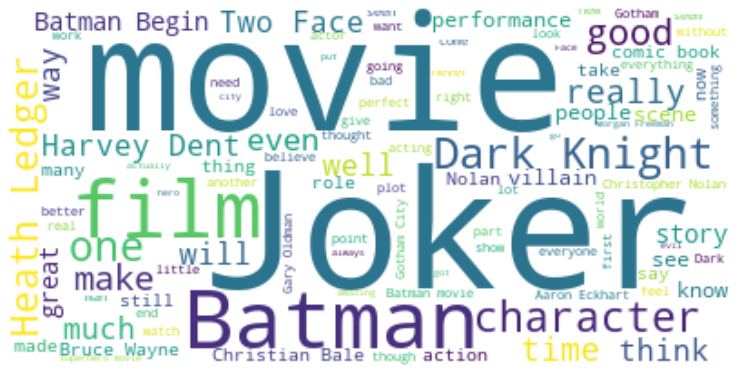

In [14]:
spoiler = " ".join(posts for posts in one_movie[one_movie['is_spoiler']==1]['review'])
print ("There are {} words in the combination of all spoiler reviews.".format(len(spoiler)))

stopwords = set(STOPWORDS)

wordcloud_spoiler = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(spoiler)

plt.figure(figsize=[13,10])
plt.imshow(wordcloud_spoiler, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 4986880 words in the combination of all non-spoiler reviews.


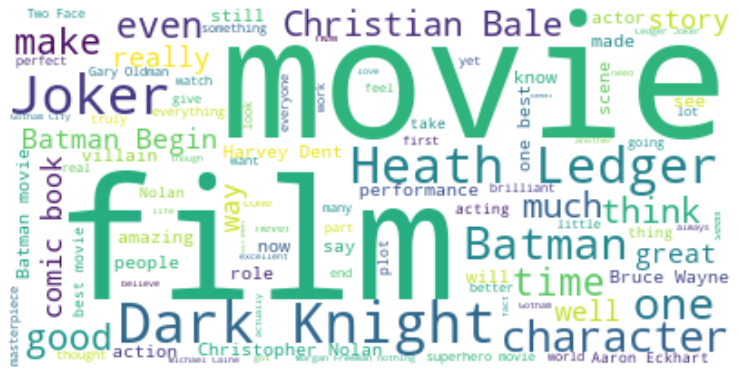

In [15]:
no_spoiler = " ".join(posts for posts in one_movie[one_movie['is_spoiler']==0]['review'])
print ("There are {} words in the combination of all non-spoiler reviews.".format(len(no_spoiler)))

stopwords = set(STOPWORDS)

wordcloud_no_spoiler = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(no_spoiler)

plt.figure(figsize=[13,10])
plt.imshow(wordcloud_no_spoiler, interpolation='bilinear')
plt.axis("off")
plt.show()

### Defining functions for later usage

Get common words to add into our stopwords later on

In [133]:
def get_top_n_words(corpus, n=25):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def find_common_words(data):
    list_of_common_words = get_top_n_words(data)
    common_words = []
    for word, freq in list_of_common_words:

        common_words.append(word)
    return common_words


Grid search for our final model

In [17]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(pipeline, parameters, refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_one_train_cleaned, y_one_train)

    # make the predictions
    y_pred = grid_search.predict(X_one_test_cleaned)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_one_test, y_pred),
                 columns=['predicted negative', 'predicted positive'], index=['true negative', 'true positive']))
    return grid_search

    

To display confusion table and classification report

In [18]:
def confusion_table(pred_y, test_y = y_one_train):
    tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
    cm = pd.DataFrame(columns=['Predicted Negative','Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
    cm['Predicted Positive'][1] = tp
    cm['Predicted Positive'][0] = fp
    cm['Predicted Negative'][1] = fn
    cm['Predicted Negative'][0] = tn
    
    print("True Negatives: %s" % tn)
    print("False Negatives: %s" % fn)
    print("False Positives: %s" % fp)
    print("True Positives: %s" % tp)
    return cm
    
def class_report(pred_y, test_y = 'y_one_train'):
    report = pd.DataFrame(classification_report(test_y, pred_y, output_dict=True))
    return report.T

## Logistic Regression with CountVectorizer

In [20]:
pipe_cv_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

pipe_params_cv_lr = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [2, 3, 4 ,5],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__class_weight': ['balanced', {1:1.5}, {1:1.75}]
}


In [21]:
rs_cv_lr = RandomizedSearchCV(pipe_cv_lr, param_distributions=pipe_params_cv_lr, cv=5)
rs_cv_lr.fit(X_one_train_cleaned, y_one_train)
print(rs_cv_lr.best_score_)
rs_cv_lr.best_params_

0.6793252014960156


{'lr__class_weight': {1: 1.5},
 'cvec__ngram_range': (1, 1),
 'cvec__min_df': 3,
 'cvec__max_features': 400,
 'cvec__max_df': 0.9}

In [22]:
print(f'Train accuracy score: {round(rs_cv_lr.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_cv_lr.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 77.9246%
Test accuracy score: 68.9769%


In [23]:
y_one_predict_cv = rs_cv_lr.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_cv)

True Negatives: 676
False Negatives: 165
False Positives: 211
True Positives: 160


,Predicted Negative,Predicted Positive
Actual Negative,676,211
Actual Positive,165,160


In [24]:
cvlr_class_report = class_report(y_one_predict_cv, y_one_test)
cvlr_class_report

,precision,recall,f1-score,support
0,0.762120,0.803805,0.782407,841.000000
1,0.492308,0.431267,0.459770,371.000000
accuracy,0.689769,0.689769,0.689769,0.689769
macro avg,0.627214,0.617536,0.621089,1212.000000
weighted avg,0.679529,0.689769,0.683646,1212.000000


## Logistic Regression with TFIDF

In [25]:
pipe_tv_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

pipe_params_tv_lr = {
    'tvec__max_features': [400, 500, 600, 700],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.85,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__class_weight': ['balanced', {1:1.25}, {1:1.5}, {1:1.75}]
}


In [26]:
rs_tv_lr = RandomizedSearchCV(pipe_tv_lr, param_distributions=pipe_params_tv_lr, cv=5)
rs_tv_lr.fit(X_one_train_cleaned, y_one_train)
print(rs_tv_lr.best_score_)
rs_tv_lr.best_params_

0.7269430581922767


{'tvec__ngram_range': (1, 1),
 'tvec__min_df': 1,
 'tvec__max_features': 600,
 'tvec__max_df': 0.95,
 'lr__class_weight': {1: 1.25}}

In [27]:
print(f'Train accuracy score: {round(rs_tv_lr.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_tv_lr.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 77.9521%
Test accuracy score: 72.3597%


In [28]:
y_one_predict_tv = rs_tv_lr.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_tv)

True Negatives: 737
False Negatives: 104
False Positives: 231
True Positives: 140


,Predicted Negative,Predicted Positive
Actual Negative,737,231
Actual Positive,104,140


In [29]:
tvlr_class_report = class_report(y_one_predict_tv, y_one_test)
tvlr_class_report

,precision,recall,f1-score,support
0,0.761364,0.876338,0.814815,841.000000
1,0.573770,0.377358,0.455285,371.000000
accuracy,0.723597,0.723597,0.723597,0.723597
macro avg,0.667567,0.626848,0.635050,1212.000000
weighted avg,0.703940,0.723597,0.704761,1212.000000


## Naive Bayes (Multinomial) with Count Vectorizer

In [61]:
pipe_cv_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params_cv_nb = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [2, 3, 4 ,5],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}


In [62]:
rs_cv_nb = RandomizedSearchCV(pipe_cv_mnb, param_distributions=pipe_params_cv_nb, cv=5)
rs_cv_nb.fit(X_one_train_cleaned, y_one_train)
print(rs_cv_nb.best_score_)
rs_cv_nb.best_params_

0.7145641736863445


{'cvec__ngram_range': (1, 1),
 'cvec__min_df': 3,
 'cvec__max_features': 600,
 'cvec__max_df': 0.9}

In [63]:
print(f'Train accuracy score: {round(rs_cv_nb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_cv_nb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 73.3829%
Test accuracy score: 69.802%


In [64]:
y_one_predict_cnb = rs_cv_nb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_cnb)

True Negatives: 661
False Negatives: 180
False Positives: 186
True Positives: 185


,Predicted Negative,Predicted Positive
Actual Negative,661,186
Actual Positive,180,185


In [65]:
cvnb_class_report = class_report(y_one_predict_cnb, y_one_test)
cvnb_class_report

,precision,recall,f1-score,support
0,0.780401,0.785969,0.783175,841.00000
1,0.506849,0.498652,0.502717,371.00000
accuracy,0.698020,0.698020,0.698020,0.69802
macro avg,0.643625,0.642311,0.642946,1212.00000
weighted avg,0.696666,0.698020,0.697326,1212.00000


## Naive Bayes (Multinomial) with TFIDF Vectorizer

In [35]:
pipe_tv_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params_tv_mnb = {
    'tvec__max_features': [400, 500, 600, 700],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.85,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}


In [36]:
rs_tv_nb = RandomizedSearchCV(pipe_tv_mnb, param_distributions=pipe_params_tv_mnb, cv=5)
rs_tv_nb.fit(X_one_train_cleaned, y_one_train)
print(rs_tv_nb.best_score_)
rs_tv_nb.best_params_

0.7153856938776284


{'tvec__ngram_range': (1, 1),
 'tvec__min_df': 4,
 'tvec__max_features': 600,
 'tvec__max_df': 0.85}

In [37]:
print(f'Train accuracy score: {round(rs_tv_nb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_tv_nb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 72.3369%
Test accuracy score: 71.7822%


In [38]:
y_one_predict_tnb = rs_tv_nb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_tnb)

True Negatives: 824
False Negatives: 17
False Positives: 325
True Positives: 46


,Predicted Negative,Predicted Positive
Actual Negative,824,325
Actual Positive,17,46


In [39]:
tvnb_class_report = class_report(y_one_predict_tnb, y_one_test)
tvnb_class_report

,precision,recall,f1-score,support
0,0.717145,0.979786,0.828141,841.000000
1,0.730159,0.123989,0.211982,371.000000
accuracy,0.717822,0.717822,0.717822,0.717822
macro avg,0.723652,0.551888,0.520061,1212.000000
weighted avg,0.721129,0.717822,0.639531,1212.000000


## Naive Bayes (Complement) with Count Vectorizer

In [40]:
pipe_cv_cnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('cnb', ComplementNB())
])

pipe_params_cv_cnb = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}


In [41]:
rs_cv_cnb = RandomizedSearchCV(pipe_cv_cnb, param_distributions=pipe_params_cv_cnb, cv=5)
rs_cv_cnb.fit(X_one_train_cleaned, y_one_train)
print(rs_cv_cnb.best_score_)
rs_cv_cnb.best_params_

0.698597959083141


{'cvec__ngram_range': (1, 1),
 'cvec__min_df': 4,
 'cvec__max_features': 600,
 'cvec__max_df': 0.9}

In [42]:
print(f'Train accuracy score: {round(rs_cv_cnb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_cv_cnb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 71.7038%
Test accuracy score: 67.7393%


In [43]:
y_one_predict_ccnb = rs_cv_cnb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_ccnb)

True Negatives: 615
False Negatives: 226
False Positives: 165
True Positives: 206


,Predicted Negative,Predicted Positive
Actual Negative,615,165
Actual Positive,226,206


In [44]:
cvcnb_class_report = class_report(y_one_predict_ccnb, y_one_test)
cvcnb_class_report

,precision,recall,f1-score,support
0,0.788462,0.731272,0.758791,841.000000
1,0.476852,0.555256,0.513076,371.000000
accuracy,0.677393,0.677393,0.677393,0.677393
macro avg,0.632657,0.643264,0.635933,1212.000000
weighted avg,0.693076,0.677393,0.683576,1212.000000


## Naive Bayes (Complement) with TFIDF Vectorizer

In [45]:
pipe_tv_cnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('cnb', ComplementNB())
])

pipe_params_tv_cnb = {
    'tvec__max_features': [400, 500, 600, 700],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.85,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}


In [46]:
rs_tv_cnb = RandomizedSearchCV(pipe_tv_cnb, param_distributions=pipe_params_tv_cnb, cv=5)
rs_tv_cnb.fit(X_one_train_cleaned, y_one_train)
print(rs_tv_cnb.best_score_)
rs_tv_cnb.best_params_

0.6845601191355849


{'tvec__ngram_range': (1, 1),
 'tvec__min_df': 4,
 'tvec__max_features': 700,
 'tvec__max_df': 0.95}

In [47]:
print(f'Train accuracy score: {round(rs_tv_cnb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_tv_cnb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 71.9516%
Test accuracy score: 67.2442%


In [48]:
y_one_predict_tcnb = rs_tv_cnb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_tcnb)

True Negatives: 590
False Negatives: 251
False Positives: 146
True Positives: 225


,Predicted Negative,Predicted Positive
Actual Negative,590,146
Actual Positive,251,225


In [49]:
tvcnb_class_report = class_report(y_one_predict_tcnb, y_one_test)
tvcnb_class_report

,precision,recall,f1-score,support
0,0.801630,0.701546,0.748256,841.000000
1,0.472689,0.606469,0.531287,371.000000
accuracy,0.672442,0.672442,0.672442,0.672442
macro avg,0.637160,0.654007,0.639772,1212.000000
weighted avg,0.700940,0.672442,0.681841,1212.000000


## SVM with Count Vectorizer

In [50]:
pipe_cv_svc = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC())
])

pipe_params_cv_svc = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__class_weight':['balanced',{1:1.25},{1:1.5},{1:1.75}]
}


In [52]:
rs_cv_svc = RandomizedSearchCV(pipe_cv_svc, param_distributions=pipe_params_cv_svc, cv=5)
rs_cv_svc.fit(X_one_train_cleaned, y_one_train)
print(rs_cv_svc.best_score_)
rs_cv_svc.best_params_

0.7244690243689869


{'svc__kernel': 'rbf',
 'svc__class_weight': {1: 1.5},
 'cvec__ngram_range': (1, 1),
 'cvec__min_df': 1,
 'cvec__max_features': 400,
 'cvec__max_df': 0.95}

In [53]:
print(f'Train accuracy score: {round(rs_cv_svc.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_cv_svc.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 86.0446%
Test accuracy score: 71.9472%


In [54]:
y_one_predict_csvc = rs_cv_svc.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_csvc)

True Negatives: 741
False Negatives: 100
False Positives: 240
True Positives: 131


,Predicted Negative,Predicted Positive
Actual Negative,741,240
Actual Positive,100,131


In [55]:
cvsvc_class_report = class_report(y_one_predict_csvc, y_one_test)
cvsvc_class_report

,precision,recall,f1-score,support
0,0.755352,0.881094,0.813392,841.000000
1,0.567100,0.353100,0.435216,371.000000
accuracy,0.719472,0.719472,0.719472,0.719472
macro avg,0.661226,0.617097,0.624304,1212.000000
weighted avg,0.697727,0.719472,0.697630,1212.000000


## SVM with TFIDF Vectorizer


In [56]:
pipe_tv_svc = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

pipe_params_tv_svc = {
    'tvec__max_features': [400, 500, 600, 700],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.85,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__class_weight':['balanced',{1:1.25},{1:1.5},{1:1.75}]
}


In [57]:
rs_tv_svc = RandomizedSearchCV(pipe_tv_svc, param_distributions=pipe_params_tv_svc, cv=5)
rs_tv_svc.fit(X_one_train_cleaned, y_one_train)
print(rs_tv_svc.best_score_)
rs_tv_svc.best_params_

0.7197865866366554


{'tvec__ngram_range': (1, 2),
 'tvec__min_df': 2,
 'tvec__max_features': 500,
 'tvec__max_df': 0.9,
 'svc__kernel': 'poly',
 'svc__class_weight': {1: 1.25}}

In [58]:
print(f'Train accuracy score: {round(rs_tv_svc.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_tv_svc.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 99.5596%
Test accuracy score: 70.6271%


In [59]:
y_one_predict_tsvc = rs_tv_svc.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_tsvc)

True Negatives: 758
False Negatives: 83
False Positives: 273
True Positives: 98


,Predicted Negative,Predicted Positive
Actual Negative,758,273
Actual Positive,83,98


In [60]:
tvsvc_class_report = class_report(y_one_predict_tsvc, y_one_test)
tvsvc_class_report

,precision,recall,f1-score,support
0,0.735209,0.901308,0.809829,841.000000
1,0.541436,0.264151,0.355072,371.000000
accuracy,0.706271,0.706271,0.706271,0.706271
macro avg,0.638322,0.582729,0.582451,1212.000000
weighted avg,0.675894,0.706271,0.670626,1212.000000


### XGBoost with Count Vectorizer

In [73]:
pipe_cv_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

pipe_params_cv_xgb = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [1, 2, 3, 4],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'xgb__n_estimators' : [200,300,400,500],
    'xgb__max_features': ['auto','sqrt','log2',None],
    'xgb__leaning_rate':[1,2,3,4]
}


In [74]:
rs_cv_xgb = RandomizedSearchCV(pipe_cv_xgb, param_distributions=pipe_params_cv_xgb, cv=5)
rs_cv_xgb.fit(X_one_train_cleaned, y_one_train)
print(rs_cv_xgb.best_score_)
rs_cv_xgb.best_params_

0.7228184053868685


{'xgb__n_estimators': 300,
 'xgb__max_features': 'log2',
 'xgb__leaning_rate': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__min_df': 3,
 'cvec__max_features': 600,
 'cvec__max_df': 0.85}

In [75]:
print(f'Train accuracy score: {round(rs_cv_xgb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_cv_xgb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 87.531%
Test accuracy score: 72.1947%


In [76]:
y_one_predict_cxgb = rs_cv_xgb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_cxgb)

True Negatives: 752
False Negatives: 89
False Positives: 248
True Positives: 123


,Predicted Negative,Predicted Positive
Actual Negative,752,248
Actual Positive,89,123


In [77]:
cxgb_class_report = class_report(y_one_predict_cxgb, y_one_test)
cxgb_class_report

,precision,recall,f1-score,support
0,0.752000,0.894174,0.816947,841.000000
1,0.580189,0.331536,0.421955,371.000000
accuracy,0.721947,0.721947,0.721947,0.721947
macro avg,0.666094,0.612855,0.619451,1212.000000
weighted avg,0.699408,0.721947,0.696038,1212.000000


### XGBoost with TFIDF Vectorizer

In [78]:
pipe_tv_xgb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

pipe_params_tv_xgb = {
    'tvec__max_features': [400, 500, 600, 700],
    'tvec__min_df': [1, 2, 3, 4],
    'tvec__max_df': [0.85,.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)],
    'xgb__n_estimators' : [200,300,400,500],
    'xgb__max_features': ['auto','sqrt','log2',None],
    'xgb__leaning_rate':[1,2,3,4]
}


In [79]:
rs_tv_xgb = RandomizedSearchCV(pipe_tv_xgb, param_distributions=pipe_params_tv_xgb, cv=5)
rs_tv_xgb.fit(X_one_train_cleaned, y_one_train)
print(rs_tv_xgb.best_score_)
rs_tv_xgb.best_params_

0.7206168222174224


{'xgb__n_estimators': 200,
 'xgb__max_features': None,
 'xgb__leaning_rate': 3,
 'tvec__ngram_range': (1, 2),
 'tvec__min_df': 1,
 'tvec__max_features': 500,
 'tvec__max_df': 0.95}

In [80]:
print(f'Train accuracy score: {round(rs_tv_xgb.score(X_one_train_cleaned, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(rs_tv_xgb.score(X_one_test_cleaned, y_one_test)*100,4)}%')

Train accuracy score: 87.531%
Test accuracy score: 71.4521%


In [81]:
y_one_predict_txgb = rs_tv_xgb.predict(X_one_test_cleaned)
confusion_table(y_one_test, y_one_predict_txgb)

True Negatives: 756
False Negatives: 85
False Positives: 261
True Positives: 110


,Predicted Negative,Predicted Positive
Actual Negative,756,261
Actual Positive,85,110


In [82]:
txgb_class_report = class_report(y_one_predict_txgb, y_one_test)
txgb_class_report

,precision,recall,f1-score,support
0,0.743363,0.898930,0.813778,841.000000
1,0.564103,0.296496,0.388693,371.000000
accuracy,0.714521,0.714521,0.714521,0.714521
macro avg,0.653733,0.597713,0.601235,1212.000000
weighted avg,0.688490,0.714521,0.683657,1212.000000


### All models comparing classification report 
- Precision score
- Recall score
- Accuracy score

In [83]:
display(cvlr_class_report[['precision','recall']][:3])
print('Logistic Regression with Count Vectorizer')

display(tvlr_class_report[['precision','recall']][:3])
print('Logistic Regression with TFIDF Vectorizer')

display(cvnb_class_report[['precision','recall']][:3])
print('Naive Bayes (Multinomial) with Count Vectorizer')

display(tvnb_class_report[['precision','recall']][:3])
print('Naive Bayes (Multinomial) with TFIDF Vectorizer')

display(cvcnb_class_report[['precision','recall']][:3])
print('Naive Bayes (Complement) with Count Vectorizer')

display(tvcnb_class_report[['precision','recall']][:3])
print('Naive Bayes (Complement) with TFIDF Vectorizer')

display(cvsvc_class_report[['precision','recall']][:3])
print('SVM SVC with Count Vectorizer')

display(tvsvc_class_report[['precision','recall']][:3])
print('SVM SVC with TFIDF Vectorizer')

display(cxgb_class_report[['precision','recall']][:3])
print('XGBoost with Count Vectorizer')

display(txgb_class_report[['precision','recall']][:3])
print('XGBoost with TFIDF Vectorizer')

,precision,recall
0,0.762120,0.803805
1,0.492308,0.431267
accuracy,0.689769,0.689769


Logistic Regression with Count Vectorizer


,precision,recall
0,0.761364,0.876338
1,0.573770,0.377358
accuracy,0.723597,0.723597


Logistic Regression with TFIDF Vectorizer


,precision,recall
0,0.780401,0.785969
1,0.506849,0.498652
accuracy,0.698020,0.698020


Naive Bayes (Multinomial) with Count Vectorizer


,precision,recall
0,0.717145,0.979786
1,0.730159,0.123989
accuracy,0.717822,0.717822


Naive Bayes (Multinomial) with TFIDF Vectorizer


,precision,recall
0,0.788462,0.731272
1,0.476852,0.555256
accuracy,0.677393,0.677393


Naive Bayes (Complement) with Count Vectorizer


,precision,recall
0,0.801630,0.701546
1,0.472689,0.606469
accuracy,0.672442,0.672442


Naive Bayes (Complement) with TFIDF Vectorizer


,precision,recall
0,0.755352,0.881094
1,0.567100,0.353100
accuracy,0.719472,0.719472


SVM SVC with Count Vectorizer


,precision,recall
0,0.735209,0.901308
1,0.541436,0.264151
accuracy,0.706271,0.706271


SVM SVC with TFIDF Vectorizer


,precision,recall
0,0.727848,0.957194
1,0.660377,0.188679
accuracy,0.721947,0.721947


Random Forest with Count Vectorizer


,precision,recall
0,0.752000,0.894174
1,0.580189,0.331536
accuracy,0.721947,0.721947


XGBoost with Count Vectorizer


,precision,recall
0,0.743363,0.898930
1,0.564103,0.296496
accuracy,0.714521,0.714521


XGBoost with TFIDF Vectorizer


### Based on the precision and recall scores, the top 4 models are:
- Logistic regression with Count Vectorizer
- Naive Bayes (Multinomial) with Count Vectorizer
- Naive Bayes (Complement) with Count Vectorizer & TFIDF Vectorizer   
**We will take a look at their confusion matrix to futher determine which is the best model**

In [196]:
print('Logistic regression with Count Vectorizer')
display(confusion_table(y_one_test, y_one_predict_cv))
print('   ')

print('Naive Bayes (Multinomial) with Count Vectorizer')
display(confusion_table(y_one_test, y_one_predict_cnb))
print('   ')

print('Naive Bayes (Complement) with Count Vectorizer')
display(confusion_table(y_one_test, y_one_predict_ccnb))
print('   ')

print('Naive Bayes (Complement) with TFIDF Vectorizer')
display(confusion_table(y_one_test, y_one_predict_tcnb))

Logistic regression with Count Vectorizer
True Negatives: 676
False Negatives: 165
False Positives: 211
True Positives: 160


,Predicted Negative,Predicted Positive
Actual Negative,676,211
Actual Positive,165,160


   
Naive Bayes (Multinomial) with Count Vectorizer
True Negatives: 661
False Negatives: 180
False Positives: 186
True Positives: 185


,Predicted Negative,Predicted Positive
Actual Negative,661,186
Actual Positive,180,185


   
Naive Bayes (Complement) with Count Vectorizer
True Negatives: 615
False Negatives: 226
False Positives: 165
True Positives: 206


,Predicted Negative,Predicted Positive
Actual Negative,615,165
Actual Positive,226,206


   
Naive Bayes (Complement) with TFIDF Vectorizer
True Negatives: 590
False Negatives: 251
False Positives: 146
True Positives: 225


,Predicted Negative,Predicted Positive
Actual Negative,590,146
Actual Positive,251,225


# Final model chosen : Naive Bayes (Multinomial) with Count Vectorizer

#### This model was chosen as it has a better balance of both Positives and Negatives 

We will first do a gridsearch on the model (with the highest recall score) and then perform feature engineering (adding more features) to see if we can increase the scores

In [85]:
final_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

final_pipe_params = {
    'cvec__max_features': [400, 500, 600, 700],
    'cvec__min_df': [2, 3, 4 ,5],
    'cvec__max_df': [0.85,.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [86]:
mnb_gs = grid_search_wrapper(final_pipe, final_pipe_params, refit_score='recall_score')

Best params for recall_score
{'cvec__max_df': 0.9, 'cvec__max_features': 700, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 2)}

Confusion matrix of Random Forest optimized for recall_score on the test data:
               predicted negative  predicted positive
true negative                 649                 192
true positive                 182                 189


In [87]:
results = pd.DataFrame(mnb_gs.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results = results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',  'param_cvec__max_df', 'param_cvec__max_features', 'param_cvec__min_df',
       'param_cvec__ngram_range', 'params']].round(3)

In [88]:
results.head(5)

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params
46,0.534,0.509,0.713,0.9,500,5,"(1, 1)","{'cvec__max_df': 0.9, 'cvec__max_features': 50..."
78,0.534,0.509,0.713,0.95,500,5,"(1, 1)","{'cvec__max_df': 0.95, 'cvec__max_features': 5..."
44,0.534,0.508,0.713,0.9,500,4,"(1, 1)","{'cvec__max_df': 0.9, 'cvec__max_features': 50..."
76,0.534,0.508,0.713,0.95,500,4,"(1, 1)","{'cvec__max_df': 0.95, 'cvec__max_features': 5..."
52,0.534,0.519,0.714,0.9,600,4,"(1, 1)","{'cvec__max_df': 0.9, 'cvec__max_features': 60..."


**Remove top 15 common words appearing in both spoiler and non-spoiler reviews with the function defined earlier**

In [134]:
find_common_words(X_one['review'])   

['movie',
 'batman',
 'joker',
 'film',
 'dark',
 'ledger',
 'knight',
 'best',
 'heath',
 'just',
 'good',
 'like',
 'great',
 'nolan',
 'time',
 'performance',
 'really',
 'character',
 'movies',
 'bale',
 'action',
 'begins',
 'dent',
 'story',
 'comic']

In [135]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
stopWords.extend(find_common_words(X_one['review']))

In [175]:
final_cvec = CountVectorizer(stop_words=stopWords, max_df = 0.9, max_features = 700, 
                             min_df = 4, ngram_range = (1, 2))
final_mnb = MultinomialNB()

In [176]:
X_one_train_cvec = final_cvec.fit_transform(X_one_train_cleaned)
X_one_test_cvec = final_cvec.transform(X_one_test_cleaned)

In [177]:
final_mnb.fit(X_one_train_cvec, y_one_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [178]:
print(f'Train accuracy score: {round(final_mnb.score(X_one_train_cvec, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(final_mnb.score(X_one_test_cvec, y_one_test)*100,4)}%')

Train accuracy score: 73.2728%
Test accuracy score: 69.4719%


In [179]:
final_y_pred = final_mnb.predict(X_one_test_cvec)

In [180]:
confusion_table(y_one_test, final_y_pred)

True Negatives: 657
False Negatives: 184
False Positives: 186
True Positives: 185


,Predicted Negative,Predicted Positive
Actual Negative,657,186
Actual Positive,184,185


In [181]:
class_report(final_y_pred, y_one_test)[['precision','recall']][:3]

,precision,recall
0,0.779359,0.781213
1,0.501355,0.498652
accuracy,0.694719,0.694719


In [182]:
df_ctrain = pd.DataFrame(X_one_train_cvec.todense(), columns=final_cvec.get_feature_names(), index=X_one_train.index)
df_ctest =  pd.DataFrame(X_one_test_cvec.todense(), columns=final_cvec.get_feature_names(), index=X_one_test.index)

### With cosine similarity on review with plot

In [144]:
plot_cvec = final_cvec.transform(plot_cleaned)

In [145]:
df_ctrain_cosine = pd.DataFrame(cosine_similarity(X_one_train_cvec, plot_cvec), columns=['cosine'], index=X_one_train.index)
df_ctest_cosine = pd.DataFrame(cosine_similarity(X_one_test_cvec, plot_cvec), columns=['cosine'], index=X_one_test.index)

In [146]:
df_ctrain_cosine['is_spoiler'] = y_one_train
df_ctest_cosine['is_spoiler'] = y_one_test

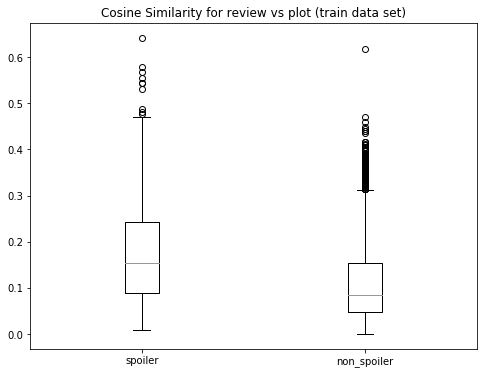

In [210]:
plt.figure(figsize = (8,6))
plt.boxplot([df_ctrain_cosine[df_ctrain_cosine['is_spoiler'] == 1]['cosine'], df_ctrain_cosine[df_ctrain_cosine['is_spoiler'] == 0]['cosine']], labels=('spoiler','non_spoiler'));
plt.title('Cosine Similarity for review vs plot (train data set)')
plt.savefig('../imgs/cosine_similarity_for_train');

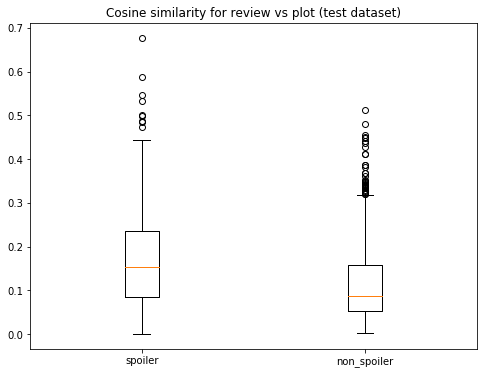

In [211]:
plt.figure(figsize = (8,6))
plt.boxplot([df_ctest_cosine[df_ctest_cosine['is_spoiler'] == 1]['cosine'], df_ctest_cosine[df_ctest_cosine['is_spoiler'] == 0]['cosine']], labels=('spoiler','non_spoiler'));
plt.title('Cosine similarity for review vs plot (test dataset)')
plt.savefig('../imgs/cosine_similarity_for_test');

The overall cosine similarity for both train and test dataset seems to be higher for spoiler reviews.

In [149]:
df_ctrain['cosine'] = df_ctrain_cosine['cosine']
df_ctest['cosine'] = df_ctest_cosine['cosine']

In [150]:
mnb = MultinomialNB()
mnb.fit(df_ctrain, y_one_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [151]:
print(f'Train accuracy score: {round(mnb.score(df_ctrain, y_one_train)*100,4)}%')
print(f'Test accuracy score: {round(mnb.score(df_ctest, y_one_test)*100,4)}%')

Train accuracy score: 73.4379%
Test accuracy score: 69.5545%


In [152]:
cosine_pred = mnb.predict(df_ctest)

In [153]:
confusion_table(y_one_test, cosine_pred)

True Negatives: 658
False Negatives: 183
False Positives: 186
True Positives: 185


,Predicted Negative,Predicted Positive
Actual Negative,658,186
Actual Positive,183,185


In [154]:
class_report(cosine_pred, y_one_test)[['precision','recall']][:3]

,precision,recall
0,0.779621,0.782402
1,0.502717,0.498652
accuracy,0.695545,0.695545


Adding cosine similarity does not seem to affect our predictions by much.

### Count Vectorizer on plot instead of reviews

In [155]:
len(plot_cleaned[0].split(' '))

3263

In [156]:
plot_cvec = CountVectorizer(stop_words=stopWords, max_df = 1, max_features = 700, 
                             min_df = 1, ngram_range = (1, 2))
plot_nmb = MultinomialNB()

In [157]:
plot_pcvec = plot_cvec.fit_transform(plot_cleaned)
X_one_train_pcvec = plot_cvec.transform(X_one_train_cleaned)
X_one_test_pcvec = plot_cvec.transform(X_one_test_cleaned)


In [158]:
X_one_train_pcvec_df = pd.DataFrame(X_one_train_pcvec.todense(), columns=plot_cvec.get_feature_names(), index=X_one_train.index)
X_one_test_pcvec_df = pd.DataFrame(X_one_test_pcvec.todense(), columns=plot_cvec.get_feature_names(), index=X_one_test.index)

In [159]:
df_ctrain_pcosine = pd.DataFrame(cosine_similarity(X_one_train_pcvec_df, plot_pcvec), columns=['cosine'], index=X_one_train.index)
df_ctest_pcosine = pd.DataFrame(cosine_similarity(X_one_test_pcvec_df, plot_pcvec), columns=['cosine'], index=X_one_test.index)

In [160]:
df_ctrain_pcosine['is_spoiler'] = y_one_train
df_ctest_pcosine['is_spoiler'] = y_one_test

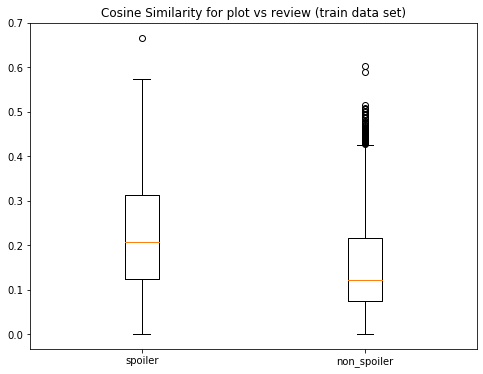

In [161]:
plt.figure(figsize = (8,6))
plt.boxplot([df_ctrain_pcosine[df_ctrain_pcosine['is_spoiler'] == 1]['cosine'], df_ctrain_pcosine[df_ctrain_pcosine['is_spoiler'] == 0]['cosine']], labels=('spoiler','non_spoiler'));
plt.title('Cosine Similarity for plot vs review (train data set)');

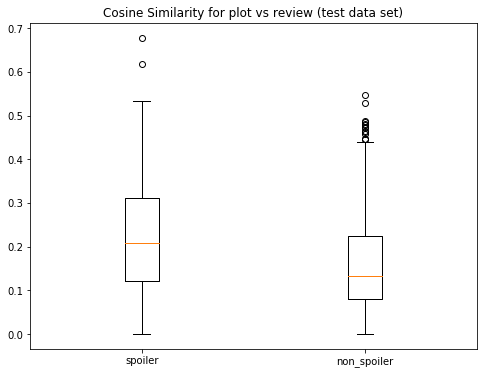

In [162]:
plt.figure(figsize = (8,6))
plt.boxplot([(df_ctest_pcosine[df_ctest_pcosine['is_spoiler'] == 1]['cosine']), df_ctest_pcosine[df_ctest_pcosine['is_spoiler'] == 0]['cosine']], labels=('spoiler','non_spoiler'));
plt.title('Cosine Similarity for plot vs review (test data set)');

Using movie as an estimate whether the review is a spoiler or not seems like a better option as we can see a distinct difference between the cosine similarities

In [200]:
X_one_train_pcvec_df['cosine'] = df_ctrain_pcosine['cosine']
X_one_test_pcvec_df['cosine'] = df_ctest_pcosine['cosine']

In [201]:
plot_nmb.fit(X_one_train_pcvec_df, y_one_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [202]:
plot_nmb.score(X_one_train_pcvec_df, y_one_train)

0.7533718689788054

In [203]:
plot_nmb.score(X_one_test_pcvec_df, y_one_test)

0.6971947194719472

In [204]:
plot_pred = plot_nmb.predict(X_one_test_pcvec_df)

In [205]:
confusion_table(y_one_test, plot_pred)

True Negatives: 706
False Negatives: 135
False Positives: 232
True Positives: 139


,Predicted Negative,Predicted Positive
Actual Negative,706,232
Actual Positive,135,139


Our results for predicting positives has decreased, we will not use cosine similarity on plot vs review as one our features.

### Predict proba graph and words affecting the review on being a spoiler or not

In [208]:
pred_proba = [i[1] for i in final_mnb.predict_proba(df_ctest)]
pred_df = pd.DataFrame({'true_values': y_one_test,'pred_probs':pred_proba})

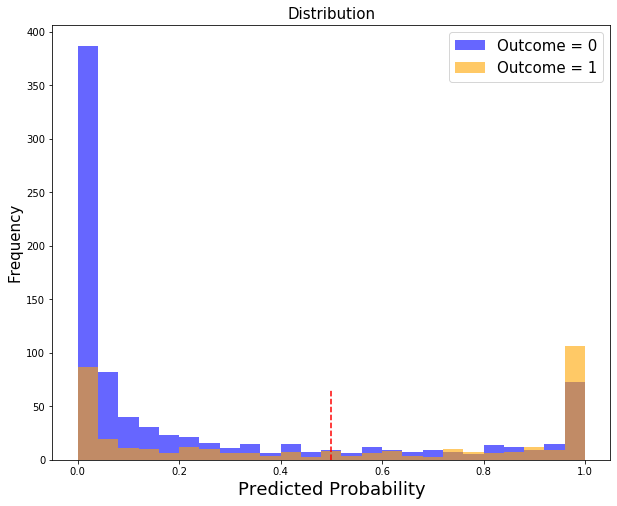

In [209]:
plt.figure(figsize = (10,8))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

plt.vlines(x=0.5, ymin = 0, ymax = 65, color='r', linestyle = '--')

plt.title('Distribution', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Predicted Probability', fontsize=18)

plt.legend(fontsize=15);

In [185]:
columns=final_cvec.get_feature_names()
final_mnb_coef = pd.DataFrame(final_mnb.coef_, columns = columns)
df_coef = final_mnb_coef.T.sort_values(by = 0, ascending = True)
df_coef


,0
describe,-8.045794
academy,-8.010703
cinematic,-8.010703
changed,-7.976801
screenplay,-7.912263
...,...
gotham,-4.763273
harvey,-4.712315
people,-4.707232
scene,-4.596941


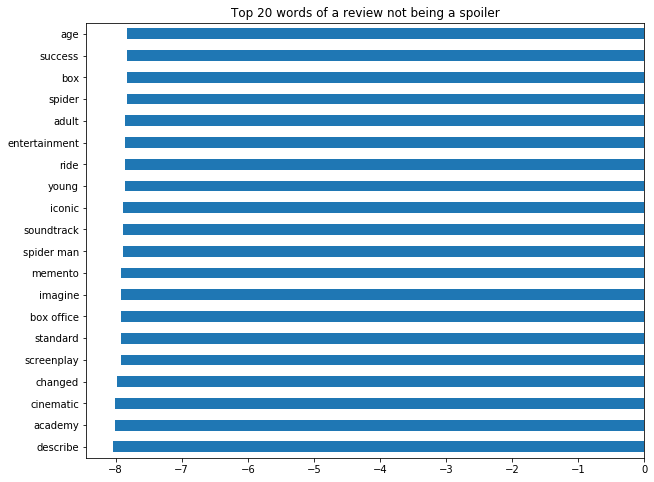

In [197]:
df_coef.head(20).plot(kind='barh', legend=False, figsize=(10,8))
plt.title('Top 20 words of a review not being a spoiler')
plt.savefig("../imgs/Top 20 words of a review not being a spoiler.png", format="png");

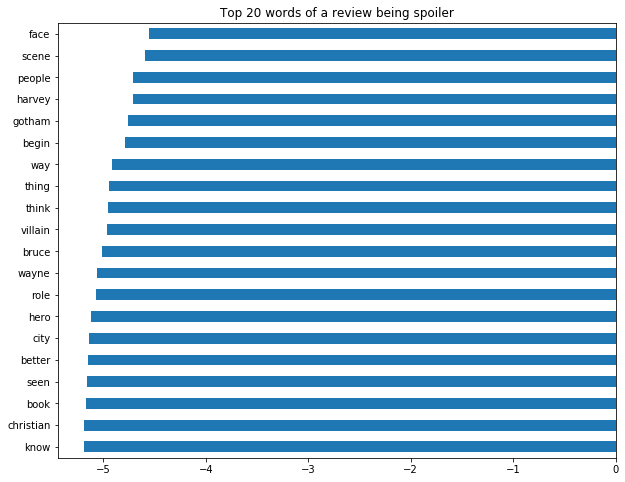

In [198]:
df_coef.tail(20).plot(kind='barh', legend=False, figsize=(10,8))
plt.title('Top 20 words of a review being spoiler')
plt.savefig("../imgs/Top 20 words of a review being a spoiler.png", format="png");

### Looking at the wrongly classified reviews 

In [188]:
pred_df = pd.DataFrame(final_y_pred, columns=['predictions'], index=y_one_test.index)
y_one_test_df = pd.DataFrame(y_one_test.values, columns=['true_y_values'], index=y_one_test.index)

In [189]:
comparison_df = pd.merge(y_one_test_df,pred_df, on=y_one_test_df.index)
comparison_df.drop(columns='key_0', inplace=True)
comparison_df.set_index(X_one_test.index, inplace=True)

In [190]:
comparison_df[comparison_df['true_y_values'] != comparison_df['predictions']]

,true_y_values,predictions
485,1,0
552,1,0
115,1,0
1675,0,1
1509,0,1
...,...,...
184,1,0
1357,1,0
934,1,0
1333,1,0


In [191]:
X_one['review'][1049]

'Epic!"Dark Knight", from start to the finish, captures you and takes you into the movie. Chris Nolan has done a fantastic job, and this movie has to go down in the history books and the best superhero movie EVER!!! As for the actors, Christian Bale is spectacular. He\'s the perfect man for the perfect role-Batman. He fits into the role so well. Michael Caine, a charismatic, classy and charming butler who is as much a butler as a mentor and guardian to a young man desperate for a path to pursue to save the people he loves. Caine is tremendously good. Morgan Freeman, as always, terrific. His version of James Bond\'s Q is much more realistic and captivating.The real star of the show, as everyone\'s been saying, is of course the late Heath Ledger. He\'s just excellent! The scene with the pencil trick is awesome, i never expected it and it hit me with a BANG!! it\'s impossible to be that good, but he\'s proved it\'s not. He\'s taken villainy to a whole new level. It\'s such a tragedy that 

### Conclusion
- Our final model - Naive Bayes (Multinomial) with Count Vectorizer has **69.4719%** accuracy with **50.1355%** in precision and **49.8652%** in recall.
- What contributed to the score not exceeding 70% could be because some of the reviews which are originally spoilers might not seem like a spoiler after reading, they were hard to determine why they were misclassified as what constitutes a spoiler is inherently a subjective assessment.
 

### Recommendations and further analysis:
- Deep learning algorithms like Dependency Parsing will be performed on the model to improve on the accuracy, sensitivity and specificity, as it recognizes a sentence and assigning a syntactic structure to it. 
- Understanding IMDB's algorithm in detecting spoiler reviews and how they work.
- Dataset need to be more comprehensive, further research should be done - each sentence with spoiler/ non-spoiler tag.
- Also users interpret spoiler & non-spoiler reviews differently, we can do a further analysis on each user's writing behaviour and if certain users leave more spoilers than others.